In [93]:
import torch 
from omegaconf import OmegaConf

In [94]:

from conditional_neural_processes.model import DeterministicCNP
from neural_processes.model import  LatentEncoder, LatentDecoder, Aggregator, LatentNP
from dataset import GPCurvesReader

In [95]:
%reload_ext autoreload
%autoreload 2

In [96]:
import torch
from tqdm import tqdm
from utils import plot_functions
import logging

log = logging.getLogger(__name__)


def train(config, 
          model, 
          data_train,
          data_test,
          ):
    """Trains the Conditional Neural Process model.

    predicts **the whole dataset** conditioned on a randomly chosen subset. 

    Args: 
        model: Conditional Neural Processes model
        data_train: `GPCurvesReader` object to generate `batch_size` curves of random number of observations and targets from a given GP process.
        data_test: `GPCurvesReader` object to generate linearly distributed test data.
        num_epochs: number of epochs to train
        lr: learning rate
        decay_rate: weight decay
    """

    lr = config.training.lr
    decay_rate = config.training.decay_rate
    num_epochs = config.training.num_epochs
    log_frequency = config.training.log_frequency

    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=decay_rate)

    for epoch in tqdm(range(1, num_epochs+1), desc=f'Training for {num_epochs} epochs'):
        train_desc = data_train.generate_curves() # generate a batch of curves
        optimizer.zero_grad()  # NOTE: zero the gradients, otherwise they will accumulate
        log_prob, _, _ = model(train_desc.query, num_total_points=train_desc.num_total_points,
                             num_contexts=train_desc.num_context_points, target_y=train_desc.target_y)
        loss = -log_prob.mean(dim=0).sum() # take mean over batch and sum over num_target and dimension of y
        loss.backward()
        optimizer.step()

        if epoch % log_frequency == 0:
            print(f'Loss: {loss.item()}')
            log.info(f'Loss: {loss.item()}')
            test_desc = data_test.generate_curves()
            (context_x_test, context_y_test), target_x_test = test_desc.query
            target_y_test = test_desc.target_y

            _, mu_test, sigma_test = model(
                test_desc.query, num_total_points=test_desc.num_total_points, num_contexts=test_desc.num_context_points)
            plot_functions(context_x_test, context_y_test, target_x_test,
                           target_y_test, mu_test.detach(), sigma_test.detach())

    return model


# Neural Processes 
$z = \mathcal{N}(\mu(r), I\sigma(r))$

In [97]:
with open("config/np_config.yaml") as file:
        cfg = OmegaConf.load(file)

encoder_num_layers = cfg.encoder.num_layers
encoder_num_units = cfg.encoder.num_units
encoder_activation_cls = cfg.encoder.activation_cls
decoder_num_layers = cfg.decoder.num_layers
decoder_num_units = cfg.decoder.num_units
decoder_activation_cls = cfg.decoder.activation_cls
aggregator_num_layers = cfg.aggregator.num_layers
aggregator_num_units = cfg.aggregator.num_units
aggregator_activation_cls = cfg.aggregator.activation_cls
r_dim = cfg.r_dim
y_size = cfg.dataset.y_size
x_size = cfg.dataset.x_size
max_num_context = cfg.dataset.max_num_context
batch_size = cfg.dataset.batch_size

In [98]:
# 1d regression dataset, sampled from a GP
data_train = GPCurvesReader(batch_size=batch_size, max_num_context=max_num_context)
data_test = GPCurvesReader(batch_size=batch_size, max_num_context=max_num_context, testing=True)

In [99]:
latent_encoder = LatentEncoder(x_size=x_size, r_dim=r_dim, y_size=y_size, num_layers=encoder_num_layers, num_units=encoder_num_units, activation_cls=encoder_activation_cls)
latent_decoder = LatentDecoder(x_size=x_size, r_dim=r_dim, y_size=y_size, num_layers=decoder_num_layers, num_units=decoder_num_units, activation_cls=decoder_activation_cls)
aggregator = Aggregator(r_dim=r_dim, num_layers=aggregator_num_layers, num_units=aggregator_num_units, activation_cls=aggregator_activation_cls)

In [100]:
latent_np = LatentNP(encoder_num_layers=encoder_num_layers,
                 encoder_num_units=encoder_num_units,
                 encoder_activation_cls=encoder_activation_cls,
                 decoder_num_layers=decoder_num_layers, 
                 decoder_num_units=decoder_num_units,
                 decoder_activation_cls=decoder_activation_cls,
                 agggreagtor_num_layers=aggregator_num_layers,
                 agggreagtor_num_units=aggregator_num_units,
                 agggreagtor_activation_cls=aggregator_activation_cls,
                 r_dim=r_dim,
                 x_size=x_size,
                 y_size=y_size)
latent_np

LatentNP(
  (_encoder): LatentEncoder(
    (_activation): ReLU()
    (_linear): ModuleList(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1-4): 4 x Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (_aggregator): Aggregator(
    (_activation): ReLU()
    (_linear): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=256, bias=True)
    )
  )
  (_decoder): LatentDecoder(
    (_activation): ReLU()
    (_linear): ModuleList(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)

Training for 200000 epochs:   2%|▏         | 4991/200000 [00:17<12:14, 265.56it/s]

Loss: 14.566316604614258


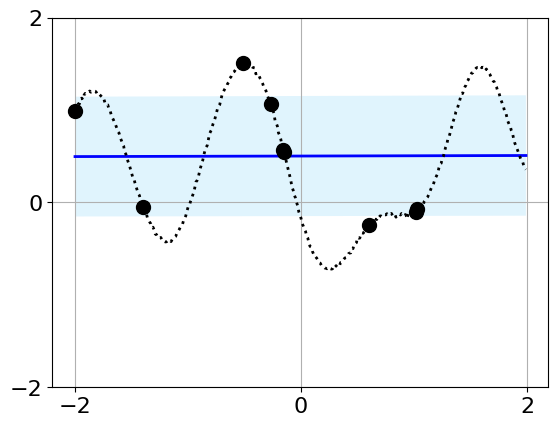

Training for 200000 epochs:   5%|▍         | 9985/200000 [00:35<10:54, 290.23it/s]

Loss: 8.36533260345459


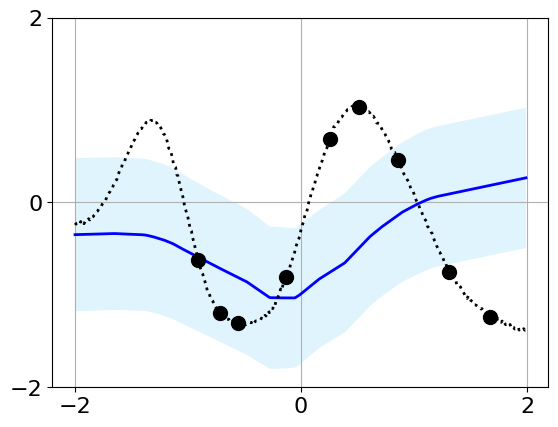

Training for 200000 epochs:   7%|▋         | 14978/200000 [00:52<10:18, 299.02it/s]

Loss: 11.593243598937988


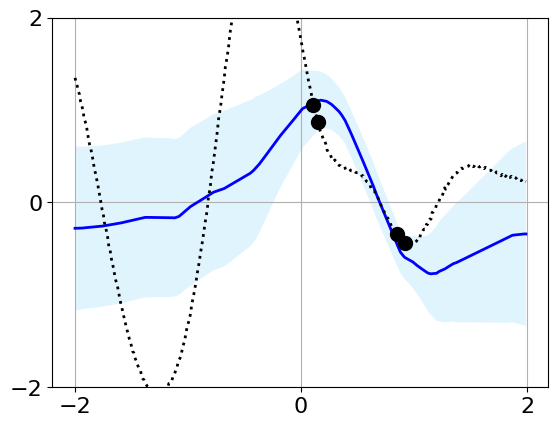

Training for 200000 epochs:  10%|▉         | 19991/200000 [01:10<10:04, 297.87it/s]

Loss: 8.693977355957031


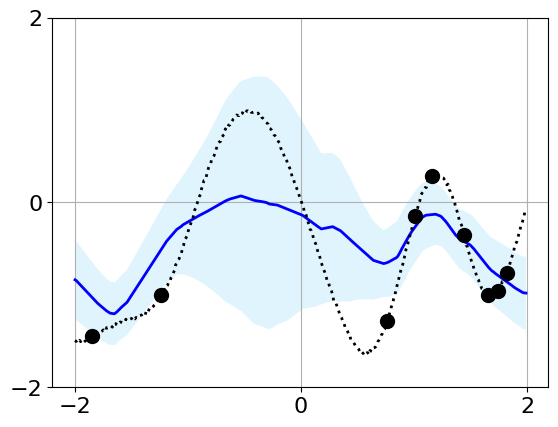

Training for 200000 epochs:  12%|█▏        | 24999/200000 [01:27<09:58, 292.36it/s]

Loss: 4.660635471343994


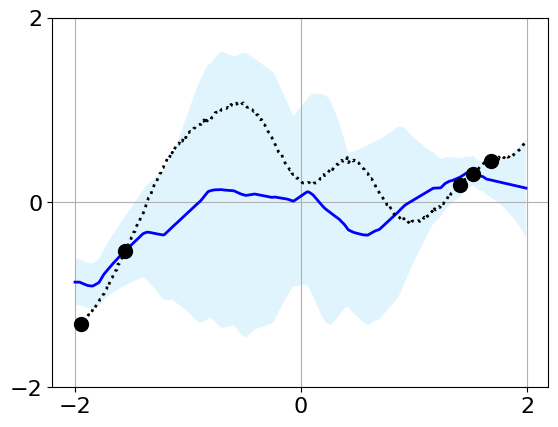

Training for 200000 epochs:  15%|█▍        | 29988/200000 [01:45<10:07, 279.80it/s]

Loss: 9.2679443359375


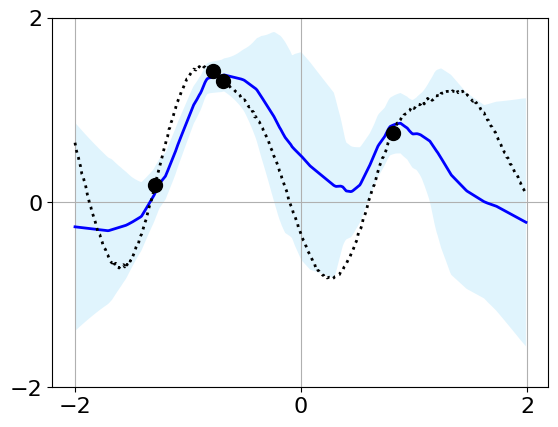

Training for 200000 epochs:  17%|█▋        | 34987/200000 [02:05<10:29, 262.22it/s]

Loss: 7.780937671661377


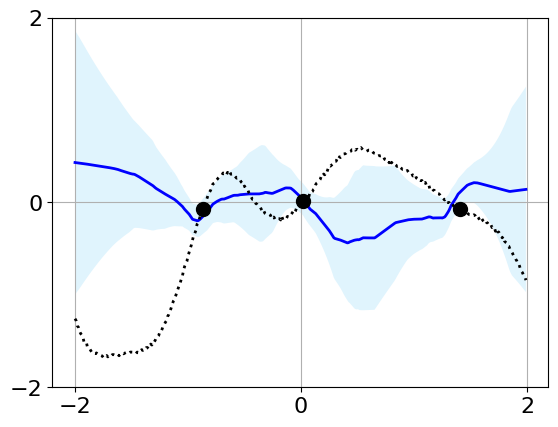

Training for 200000 epochs:  20%|█▉        | 39978/200000 [02:23<11:09, 238.93it/s]

Loss: 8.328256607055664


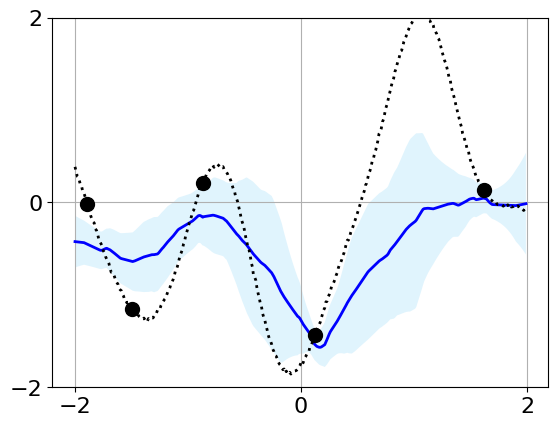

Training for 200000 epochs:  22%|██▏       | 44973/200000 [02:42<08:30, 303.49it/s]

Loss: 5.33646297454834


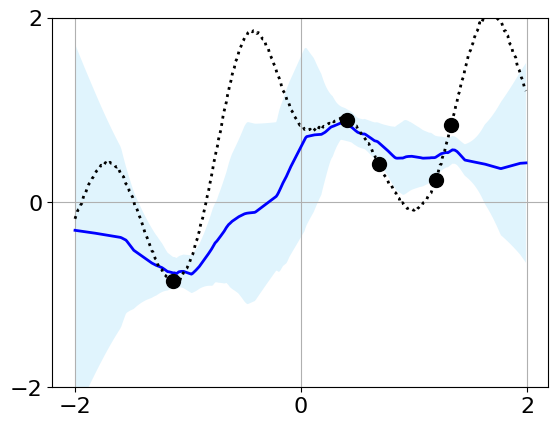

Training for 200000 epochs:  25%|██▍       | 49984/200000 [03:00<09:40, 258.59it/s]

Loss: 2.232785224914551


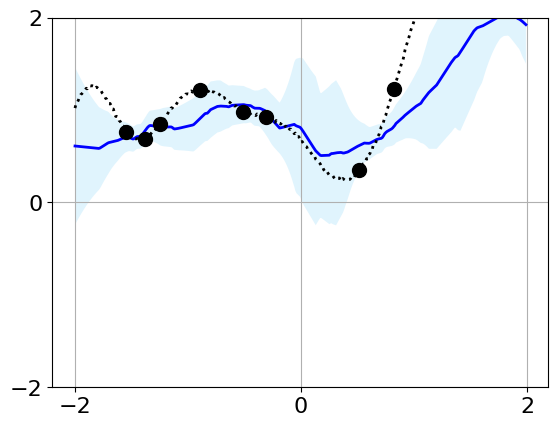

Training for 200000 epochs:  27%|██▋       | 54995/200000 [03:17<09:50, 245.74it/s]

Loss: 4.081707954406738


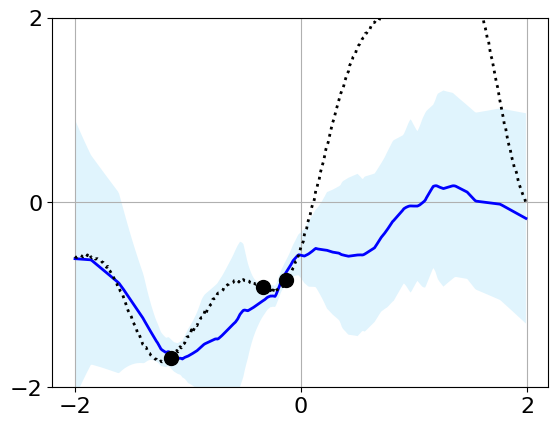

Training for 200000 epochs:  30%|██▉       | 59978/200000 [03:35<07:17, 319.71it/s]

Loss: 4.2158918380737305


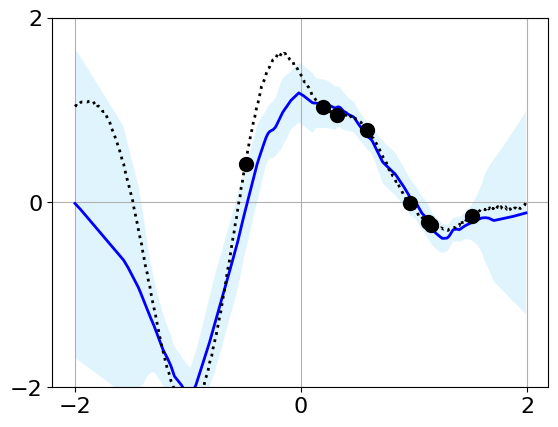

Training for 200000 epochs:  32%|███▏      | 64988/200000 [03:51<07:44, 290.79it/s]

Loss: -0.22944462299346924


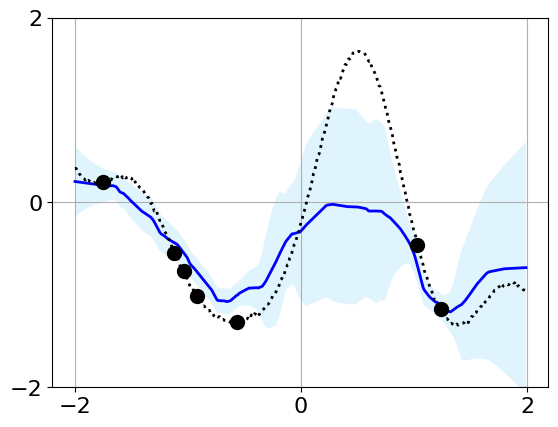

Training for 200000 epochs:  35%|███▍      | 69970/200000 [04:07<06:43, 322.48it/s]

Loss: -1.2564501762390137


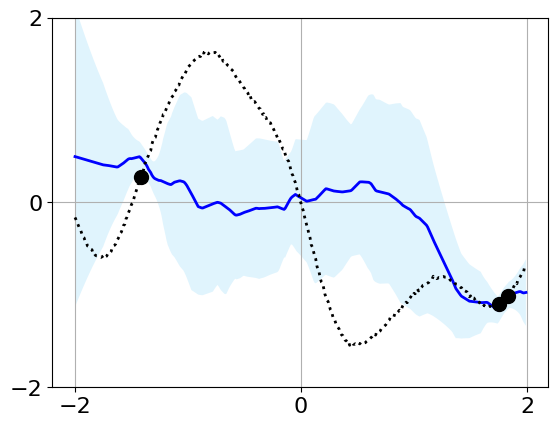

Training for 200000 epochs:  37%|███▋      | 74992/200000 [04:23<06:23, 325.56it/s]

Loss: -2.7820451259613037


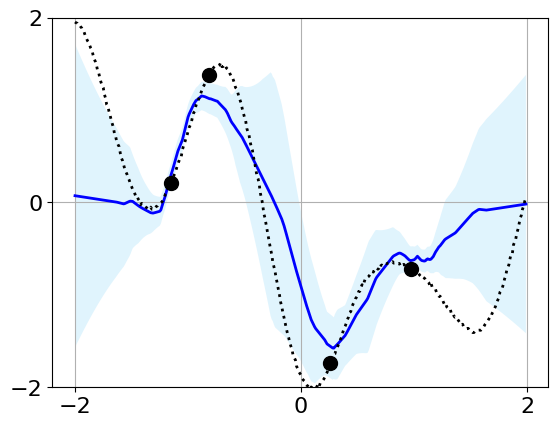

Training for 200000 epochs:  40%|███▉      | 79979/200000 [04:39<06:14, 320.13it/s]

Loss: 0.8927068114280701


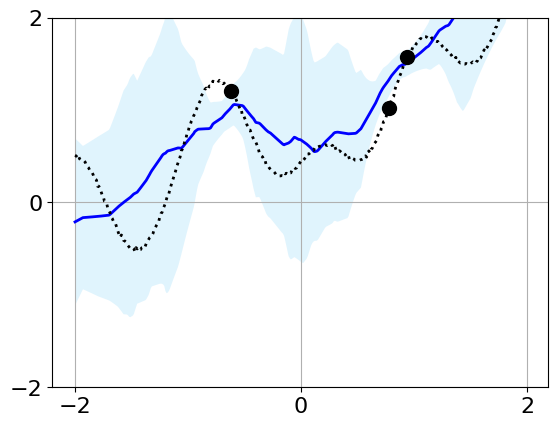

Training for 200000 epochs:  42%|████▏     | 84981/200000 [04:56<06:08, 311.95it/s]

Loss: -0.7965182662010193


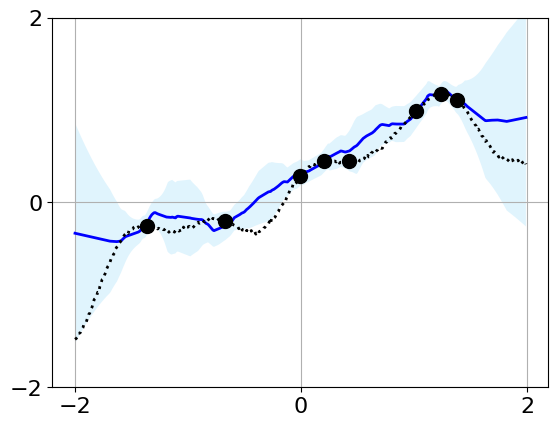

Training for 200000 epochs:  45%|████▍     | 89989/200000 [05:11<05:31, 331.73it/s]

Loss: 1.395754098892212


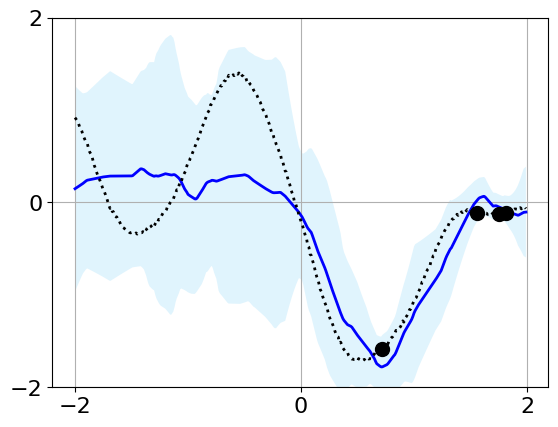

Training for 200000 epochs:  47%|████▋     | 94974/200000 [05:27<05:38, 310.18it/s]

Loss: -1.3420777320861816


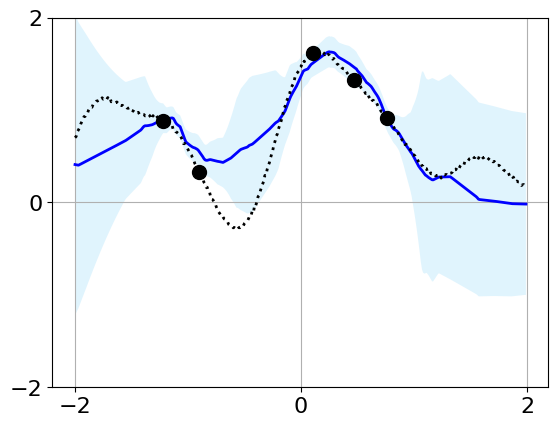

Training for 200000 epochs:  50%|████▉     | 99971/200000 [05:43<06:03, 275.07it/s]

Loss: -0.16329693794250488


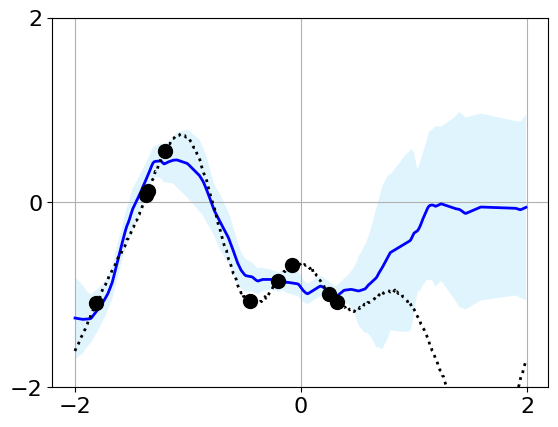

Training for 200000 epochs:  52%|█████▏    | 104991/200000 [06:01<05:24, 292.84it/s]

Loss: -1.0082378387451172


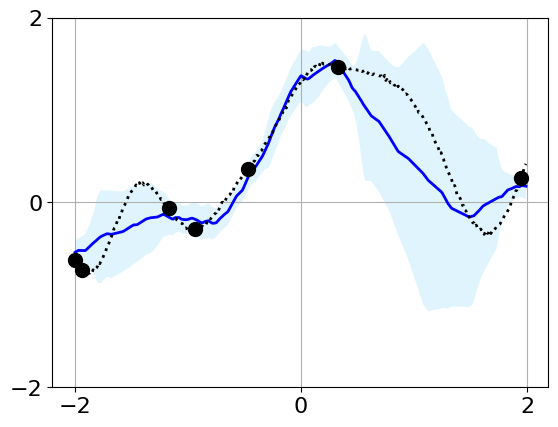

Training for 200000 epochs:  55%|█████▍    | 109984/200000 [06:18<04:44, 316.96it/s]

Loss: 0.9036958813667297


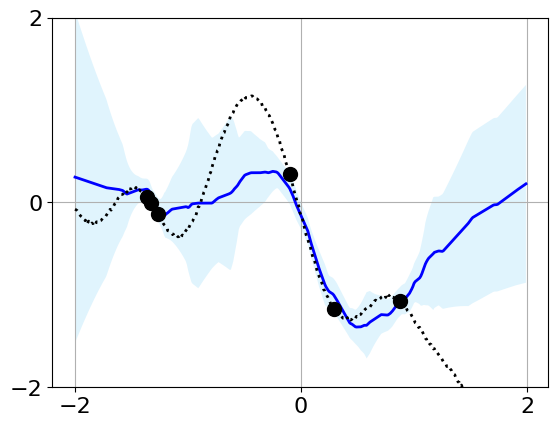

Training for 200000 epochs:  57%|█████▋    | 114978/200000 [06:35<05:18, 267.04it/s]

Loss: -2.1041972637176514


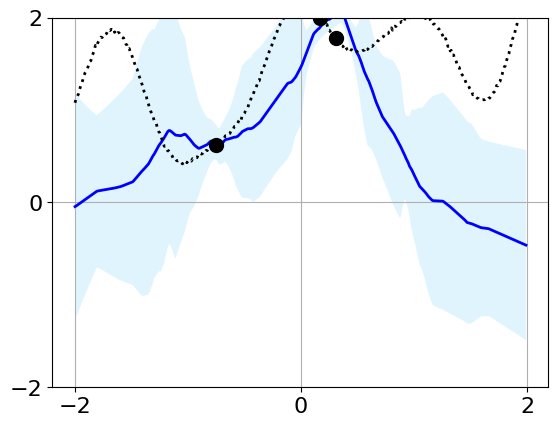

Training for 200000 epochs:  60%|█████▉    | 119987/200000 [06:52<04:11, 317.51it/s]

Loss: 4.416476249694824


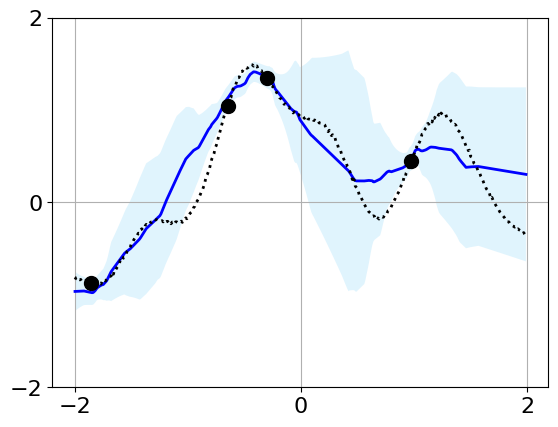

Training for 200000 epochs:  62%|██████▏   | 124982/200000 [07:09<03:56, 317.63it/s]

Loss: -2.5617918968200684


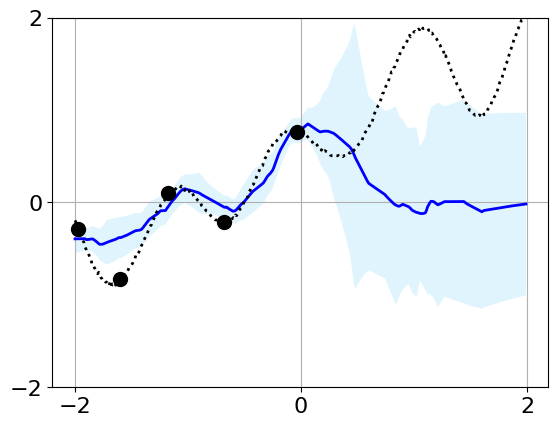

Training for 200000 epochs:  65%|██████▍   | 129989/200000 [07:26<03:44, 311.75it/s]

Loss: -2.532496213912964


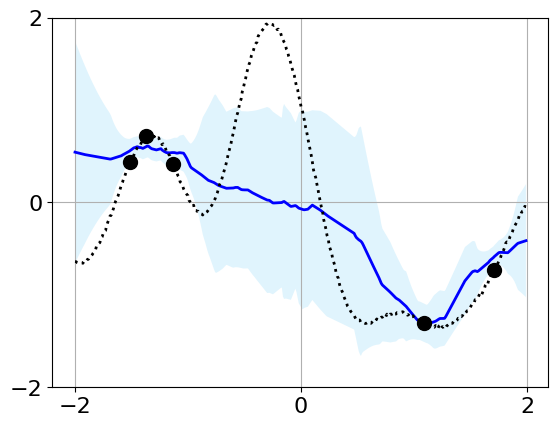

Training for 200000 epochs:  67%|██████▋   | 134991/200000 [07:44<03:54, 277.51it/s]

Loss: -1.4295549392700195


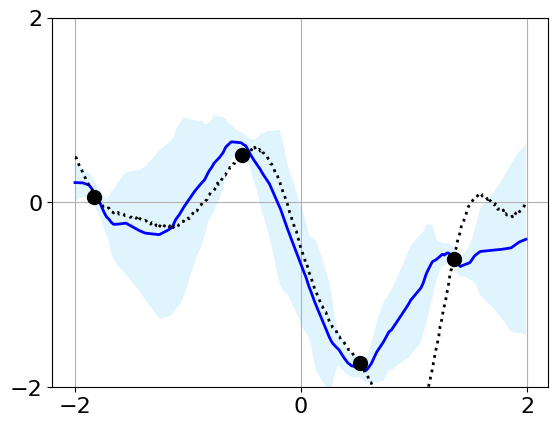

Training for 200000 epochs:  70%|██████▉   | 139998/200000 [08:02<03:52, 258.16it/s]

Loss: 1.428279995918274


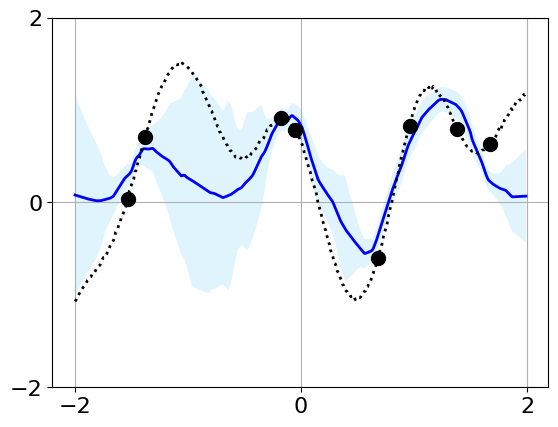

Training for 200000 epochs:  72%|███████▏  | 144998/200000 [08:21<03:11, 287.24it/s]

Loss: 1.0985729694366455


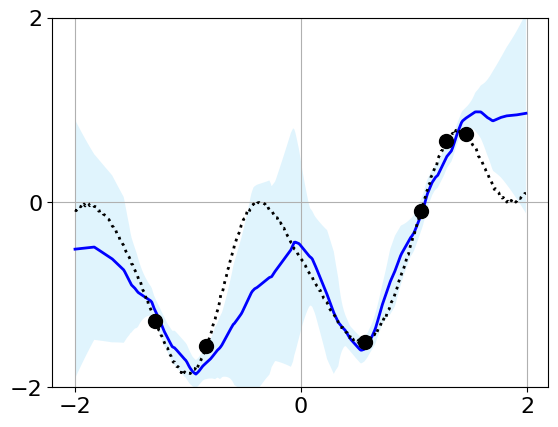

Training for 200000 epochs:  75%|███████▍  | 149977/200000 [08:39<02:46, 299.61it/s]

Loss: -0.7689248919487


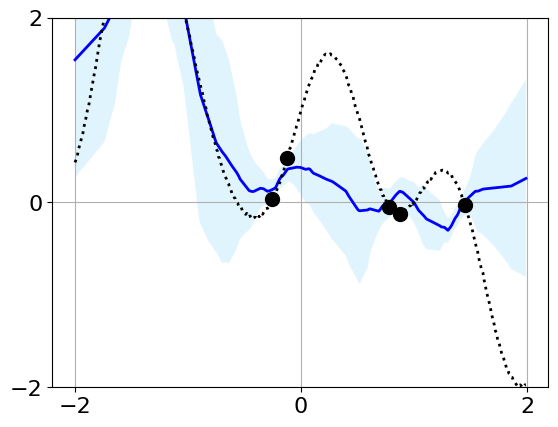

Training for 200000 epochs:  77%|███████▋  | 154973/200000 [08:57<02:39, 281.81it/s]

Loss: -2.3408608436584473


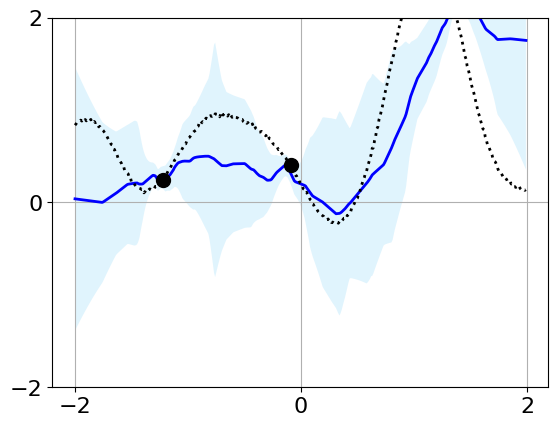

Training for 200000 epochs:  80%|███████▉  | 159982/200000 [09:15<02:26, 272.73it/s]

Loss: -4.255251407623291


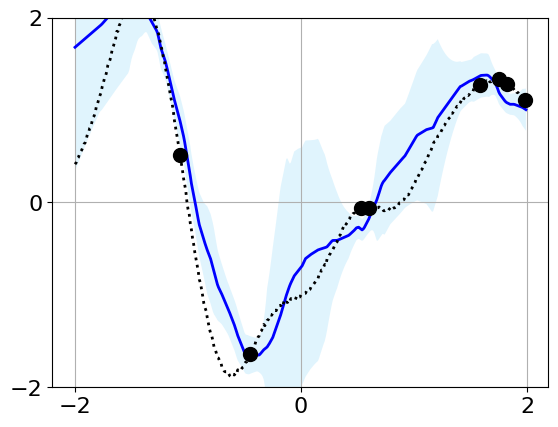

Training for 200000 epochs:  82%|████████▏ | 164991/200000 [09:34<02:05, 278.59it/s]

Loss: -2.706171751022339


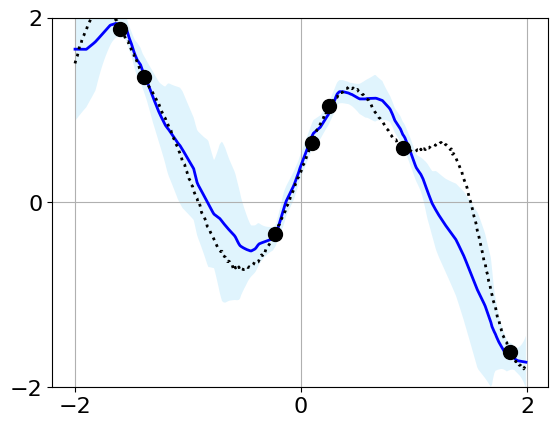

Training for 200000 epochs:  85%|████████▍ | 169972/200000 [09:51<01:33, 321.48it/s]

Loss: -1.2576169967651367


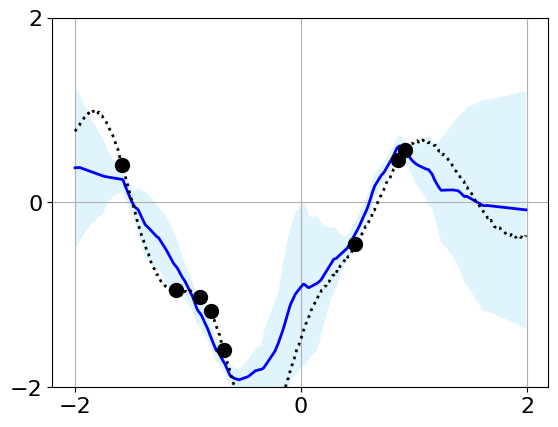

Training for 200000 epochs:  87%|████████▋ | 174989/200000 [10:07<01:16, 328.66it/s]

Loss: 0.8939482569694519


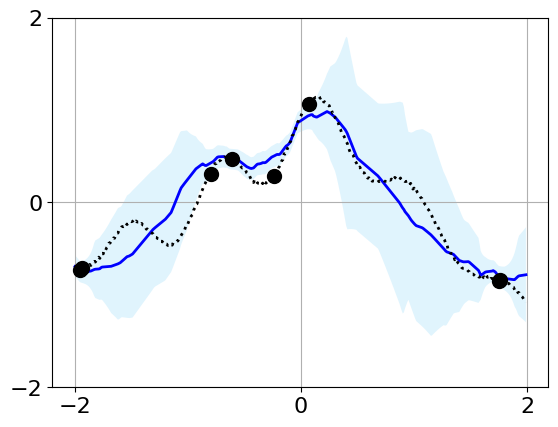

Training for 200000 epochs:  90%|████████▉ | 179991/200000 [10:22<00:59, 335.96it/s]

Loss: 4.097261905670166


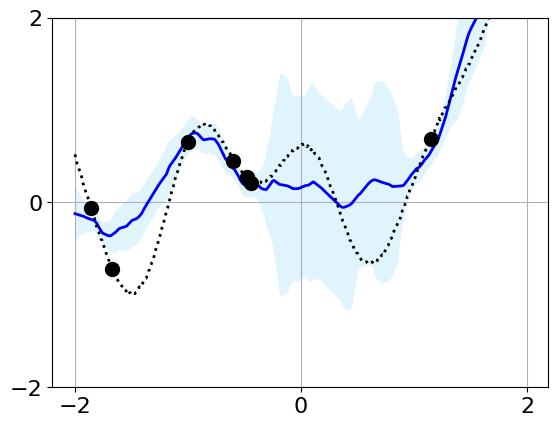

Training for 200000 epochs:  92%|█████████▏| 184969/200000 [10:38<00:47, 314.01it/s]

Loss: -4.579668998718262


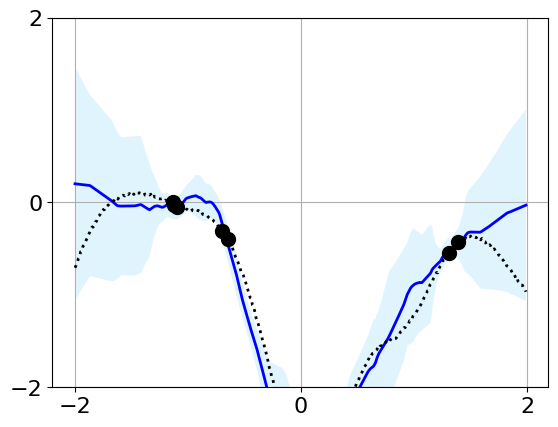

Training for 200000 epochs:  95%|█████████▍| 189977/200000 [10:53<00:32, 312.94it/s]

Loss: -2.742253541946411


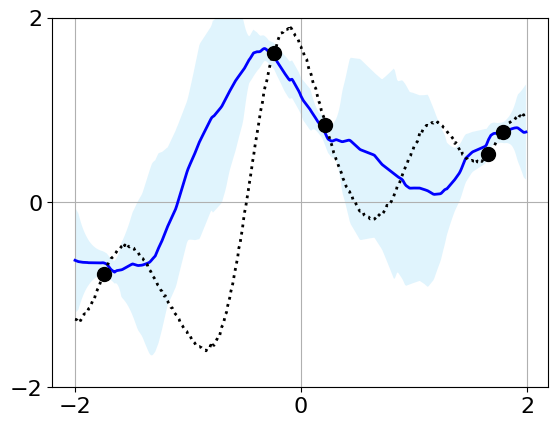

Training for 200000 epochs:  97%|█████████▋| 194990/200000 [11:09<00:15, 318.97it/s]

Loss: -3.663377523422241


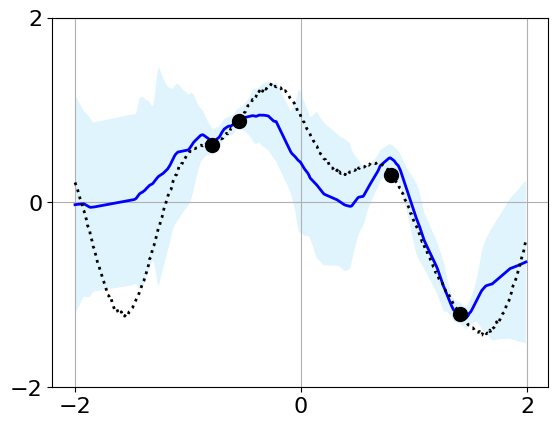

Training for 200000 epochs: 100%|█████████▉| 199995/200000 [11:25<00:00, 316.88it/s]

Loss: -2.2680695056915283


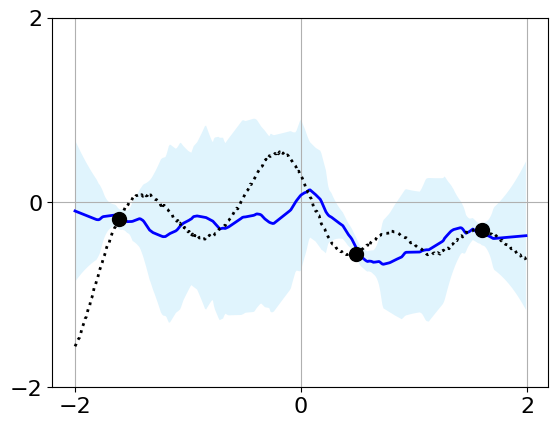

Training for 200000 epochs: 100%|██████████| 200000/200000 [11:25<00:00, 291.70it/s]


In [101]:
latent_np = train(config=cfg, model=latent_np, data_train=data_train, data_test=data_test)

In [104]:
torch.save(latent_np, 'neural_processes/trained_model/np.pt')

# Conditional Neural Processes (CNP)
## Reference
[Conditional Neural Processes](https://arxiv.org/abs/1807.01613)

[The Neural Processes Family - GitHub](https://github.com/google-deepmind/neural-processes/tree/master)
## The CNP model 
- An **encoder** $h$ from input space into representation space that takes in *pairs* of $(x, y)$, context values and produces a representation $r_i = h((x, y)_i)$ for each of the pairs. $h$ is parameterised as a neural network. 
- An **aggregator** $a$ that summarises the encoded inputs. A single order-invariant global representation $r$ is obtained, and the simplest operation that ensures order-invariance and works well in practice is the mean function $r=a(r_i) = \frac{1}{n}\sum_{i=1}^n r_i$. 
- A **decoder** $g$ that takes as input the global representation $r$ as well as the new target locations $x_T$ and outputs embedding $\phi_T$ that parameterises the output distribution. 
    - For regression tasks, $\Phi_i$ parameterises the mean and variance $\phi_i(\mu_i, \sigma_i^2)$  of a Gaussian distribution $\mathcal{N}(\mu_i, \sigma_i^2)$ for every $x_i \in T$. 
   

In [ ]:
with open("config/cnp_config.yaml") as file:
        cfg = OmegaConf.load(file)

encoder_num_layers = cfg.encoder.num_layers
encoder_num_units = cfg.encoder.num_units
encoder_activation_cls = cfg.encoder.activation_cls
decoder_num_layers = cfg.decoder.num_layers
decoder_num_units = cfg.decoder.num_units
decoder_activation_cls = cfg.decoder.activation_cls
r_dim = cfg.r_dim
y_size = cfg.dataset.y_size
x_size = cfg.dataset.x_size
max_num_context = cfg.dataset.max_num_context
batch_size = cfg.dataset.batch_size

In [ ]:
deterministic_cnp = DeterministicCNP(encoder_num_layers=encoder_num_layers, encoder_num_units=encoder_num_units, encoder_activation_cls=encoder_activation_cls, 
                                     decoder_num_layers=decoder_num_layers, decoder_num_units=decoder_num_units, decoder_activation_cls=decoder_activation_cls,
                                     r_dim=r_dim, y_size=y_size, x_size=x_size)
deterministic_cnp

DeterministicCNP(
  (_encoder): DeterministicEncoder(
    (_activation): ReLU()
    (_linear): ModuleList(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1-4): 4 x Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (_activation): ReLU()
    (_linear): ModuleList(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)

Training for 200000 epochs:   2%|▏         | 4972/200000 [00:12<07:33, 430.02it/s]

Loss: 4.157233238220215


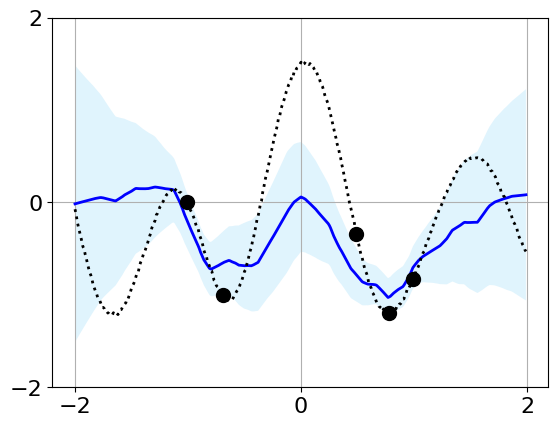

Training for 200000 epochs:   5%|▍         | 9981/200000 [00:27<08:37, 367.07it/s]

Loss: 1.7788071632385254


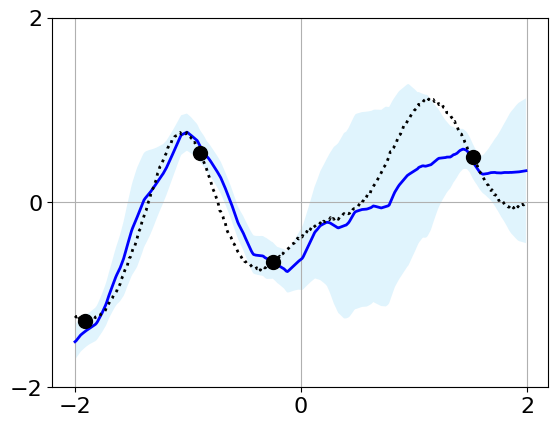

Training for 200000 epochs:   7%|▋         | 14986/200000 [00:41<08:12, 375.69it/s]

Loss: -1.2261189222335815


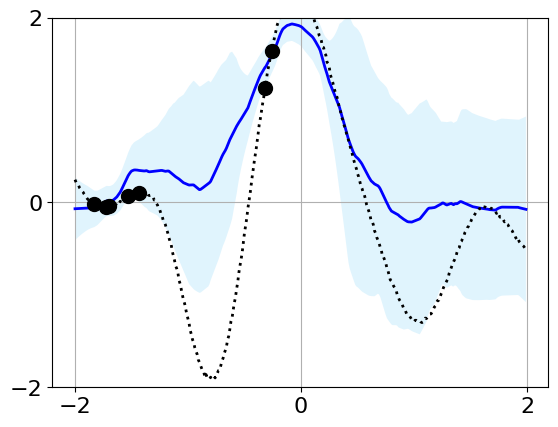

Training for 200000 epochs:  10%|▉         | 19993/200000 [00:55<08:03, 372.66it/s]

Loss: 1.0807685852050781


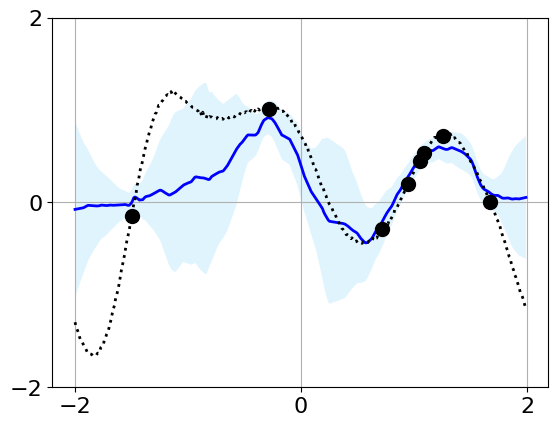

Training for 200000 epochs:  12%|█▏        | 24983/200000 [01:08<07:50, 372.37it/s]

Loss: 6.278063774108887


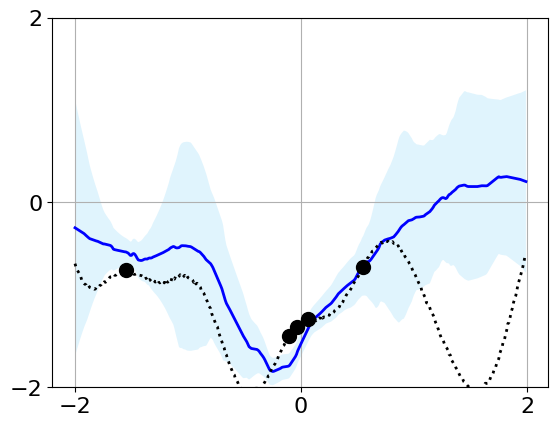

Training for 200000 epochs:  15%|█▍        | 29959/200000 [01:20<06:32, 432.70it/s]

Loss: -1.2984116077423096


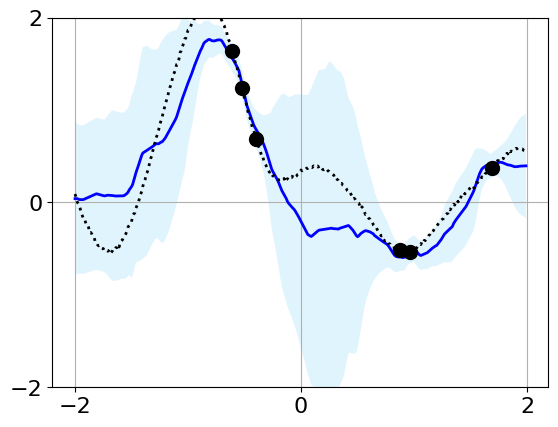

Training for 200000 epochs:  17%|█▋        | 34975/200000 [01:34<07:16, 377.66it/s]

Loss: -0.13251221179962158


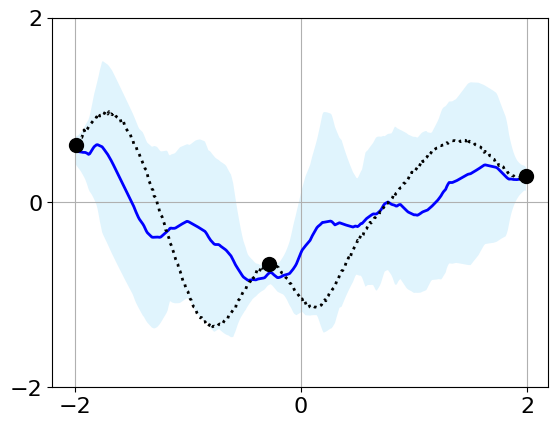

Training for 200000 epochs:  20%|█▉        | 39979/200000 [01:47<07:11, 371.03it/s]

Loss: 7.386239051818848


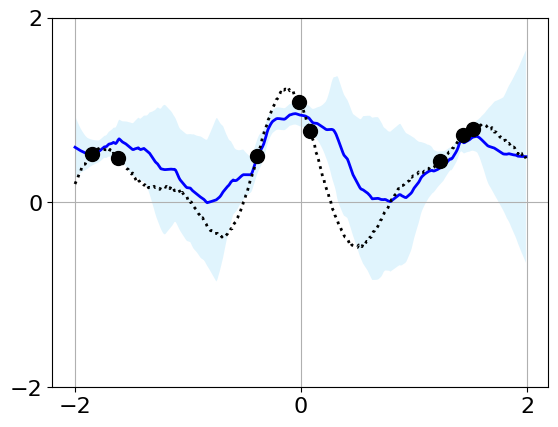

Training for 200000 epochs:  22%|██▏       | 44993/200000 [02:00<06:15, 413.35it/s]

Loss: 7.115124702453613


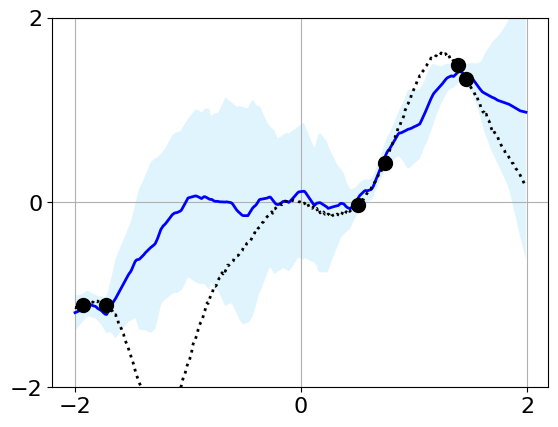

Training for 200000 epochs:  25%|██▍       | 49985/200000 [02:14<05:53, 423.95it/s]

Loss: -0.12115609645843506


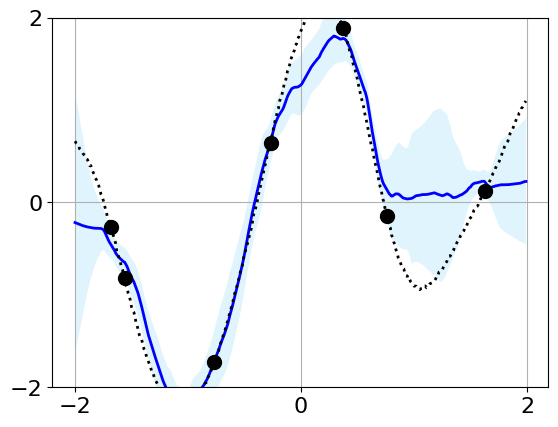

Training for 200000 epochs:  27%|██▋       | 54961/200000 [02:29<06:52, 351.47it/s]

Loss: -2.5024020671844482


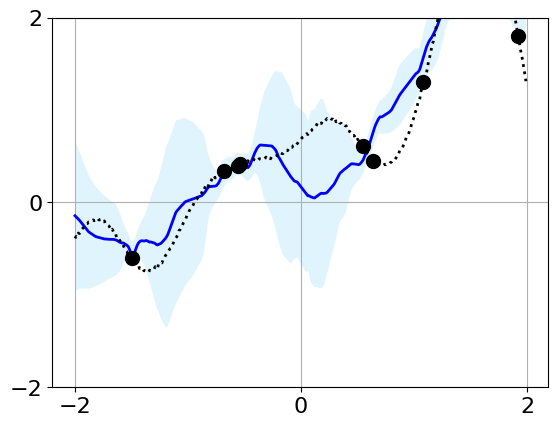

Training for 200000 epochs:  30%|██▉       | 59980/200000 [02:41<05:31, 422.44it/s]

Loss: -4.712174892425537


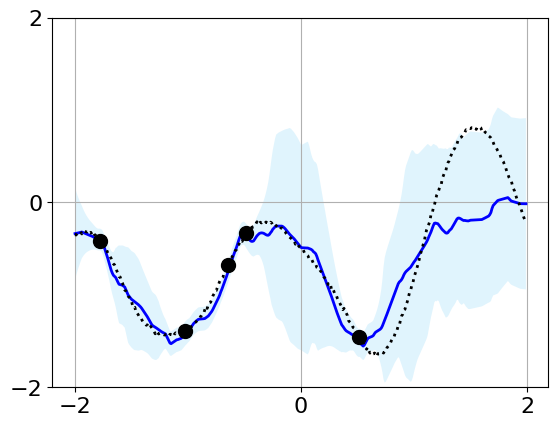

Training for 200000 epochs:  32%|███▏      | 64961/200000 [02:54<05:14, 429.40it/s]

Loss: -2.137758493423462


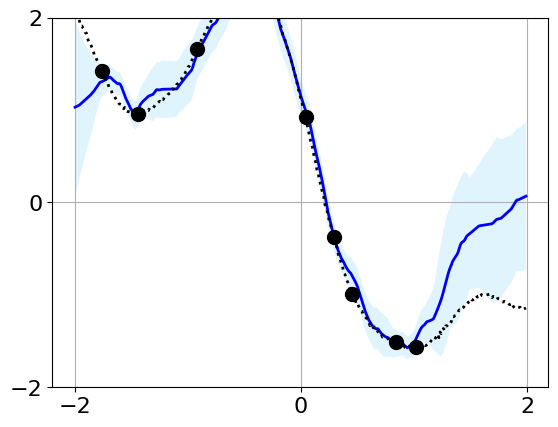

Training for 200000 epochs:  35%|███▍      | 69984/200000 [03:09<06:28, 334.99it/s]

Loss: -1.6010109186172485


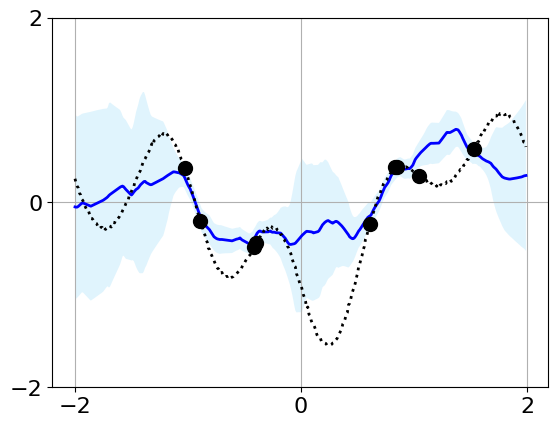

Training for 200000 epochs:  37%|███▋      | 74983/200000 [03:22<05:41, 365.86it/s]

Loss: 7.104575157165527


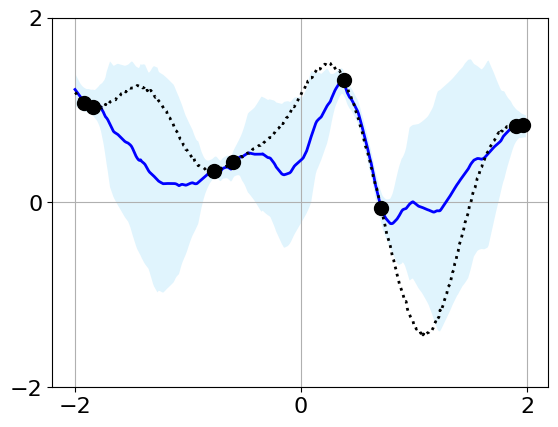

Training for 200000 epochs:  40%|███▉      | 79974/200000 [03:36<04:55, 406.23it/s]

Loss: -3.8349030017852783


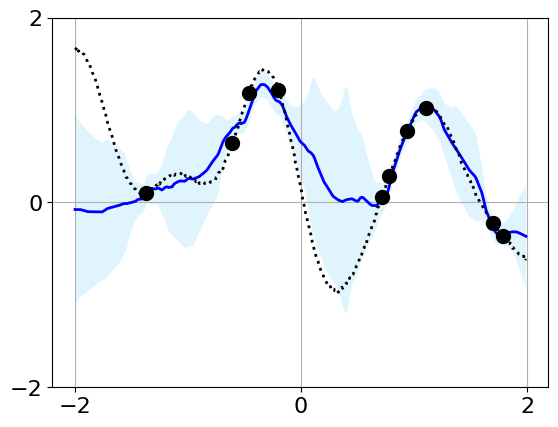

Training for 200000 epochs:  42%|████▏     | 84968/200000 [03:49<04:36, 416.16it/s]

Loss: -3.189706802368164


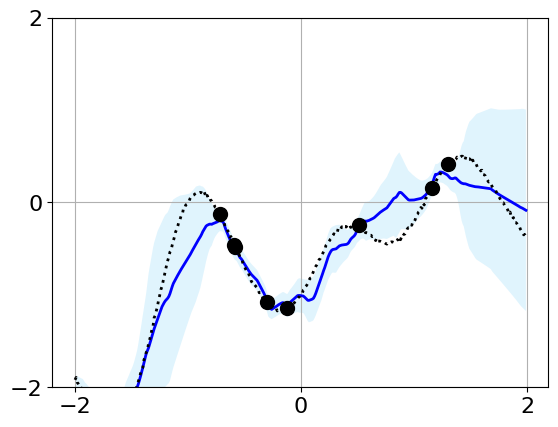

Training for 200000 epochs:  45%|████▍     | 89984/200000 [04:03<04:52, 376.16it/s]

Loss: -3.6442933082580566


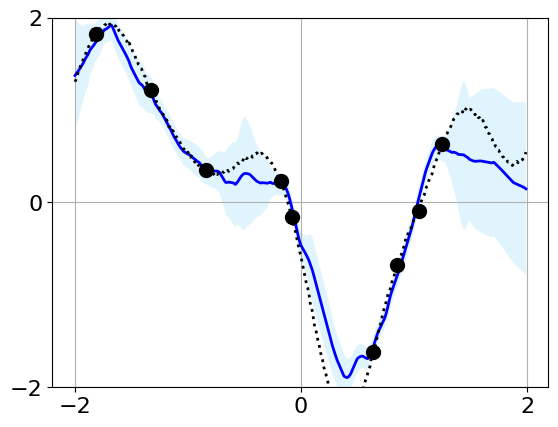

Training for 200000 epochs:  47%|████▋     | 94992/200000 [04:16<04:05, 427.75it/s]

Loss: -6.442963600158691


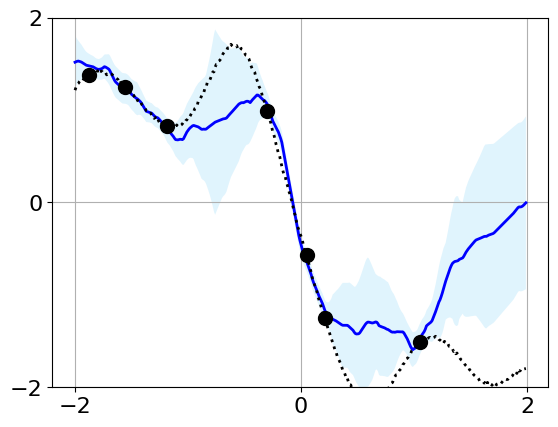

Training for 200000 epochs:  50%|████▉     | 99968/200000 [04:29<04:23, 379.02it/s]

Loss: -5.780570030212402


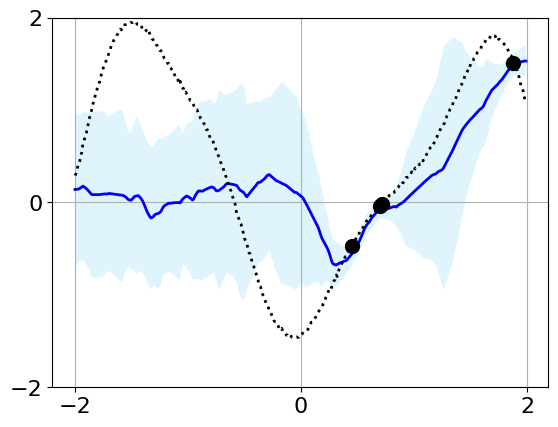

Training for 200000 epochs:  52%|█████▏    | 104992/200000 [04:42<04:48, 329.79it/s]

Loss: -6.494671821594238


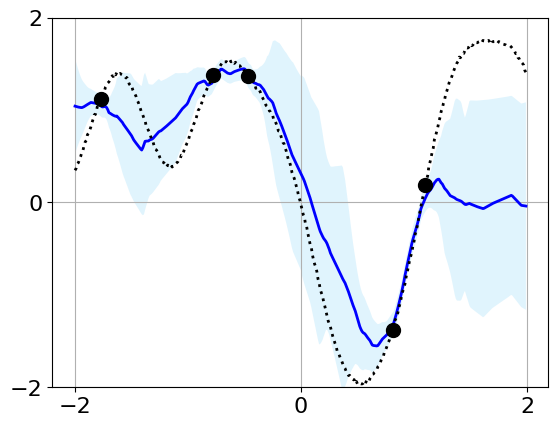

Training for 200000 epochs:  55%|█████▍    | 109992/200000 [04:55<03:51, 388.66it/s]

Loss: -5.714478969573975


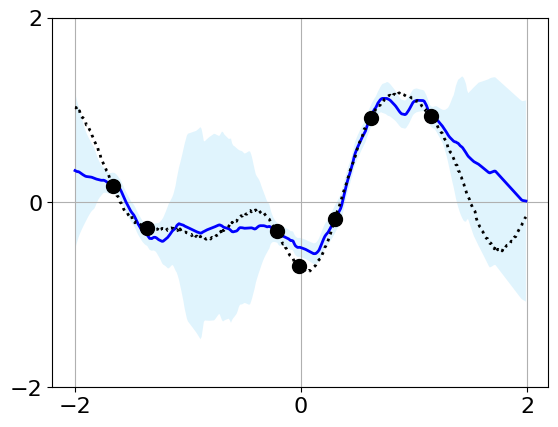

Training for 200000 epochs:  57%|█████▋    | 114986/200000 [05:08<03:19, 425.45it/s]

Loss: -2.2920756340026855


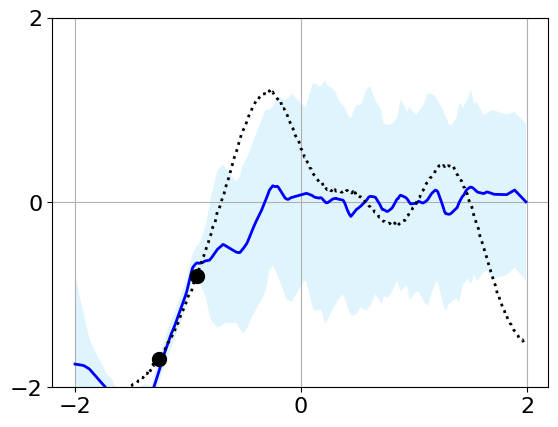

Training for 200000 epochs:  60%|█████▉    | 119967/200000 [05:22<03:31, 378.22it/s]

Loss: 3.7804622650146484


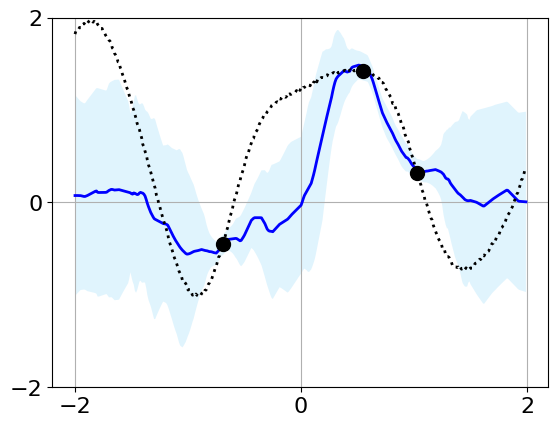

Training for 200000 epochs:  62%|██████▏   | 124987/200000 [05:34<03:35, 348.74it/s]

Loss: 6.62290096282959


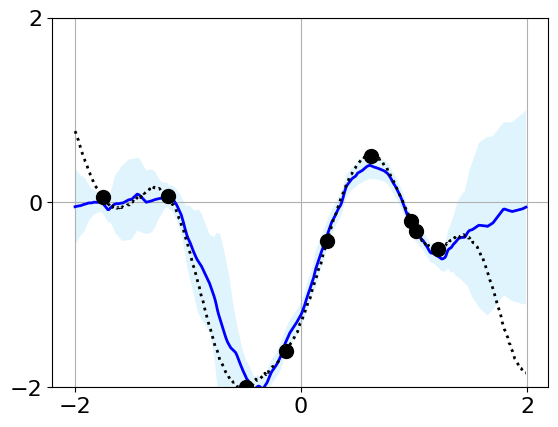

Training for 200000 epochs:  65%|██████▍   | 129996/200000 [05:49<03:20, 348.79it/s]

Loss: -0.24644410610198975


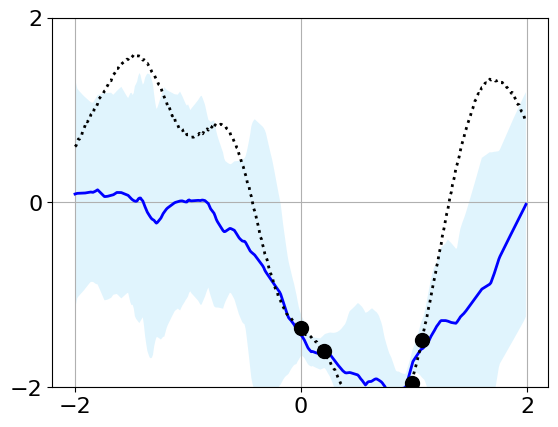

Training for 200000 epochs:  67%|██████▋   | 134966/200000 [06:02<02:54, 373.38it/s]

Loss: -1.8943493366241455


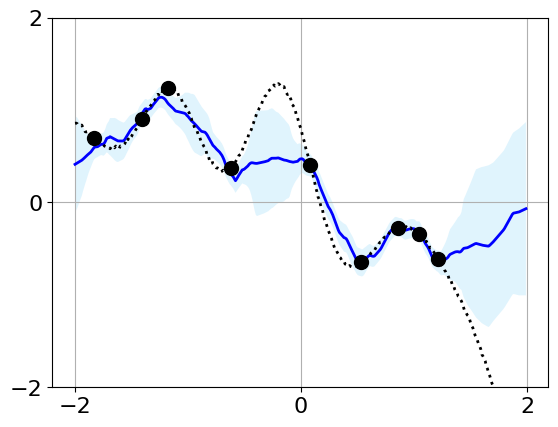

Training for 200000 epochs:  70%|██████▉   | 139989/200000 [06:16<02:43, 367.15it/s]

Loss: -3.830188274383545


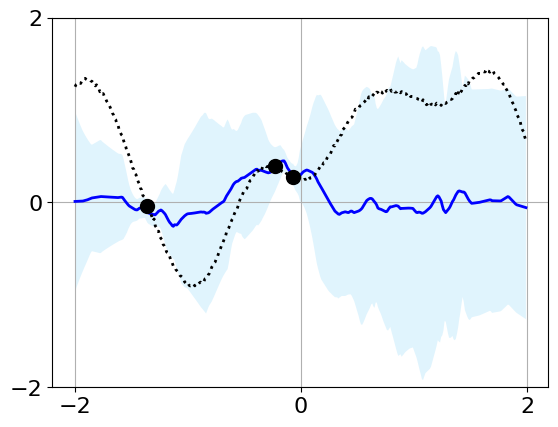

Training for 200000 epochs:  72%|███████▏  | 144985/200000 [06:30<02:28, 371.44it/s]

Loss: -5.678008556365967


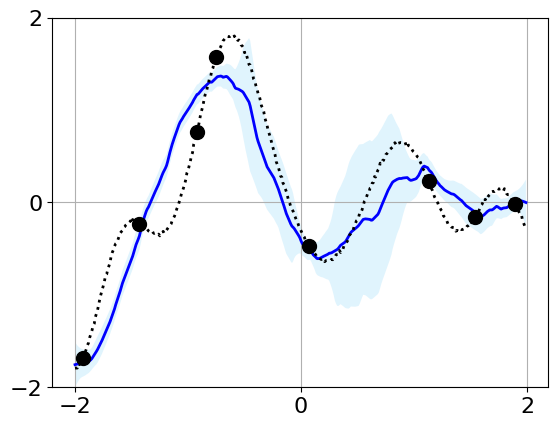

Training for 200000 epochs:  75%|███████▍  | 149990/200000 [06:43<01:56, 427.78it/s]

Loss: 1.041736364364624


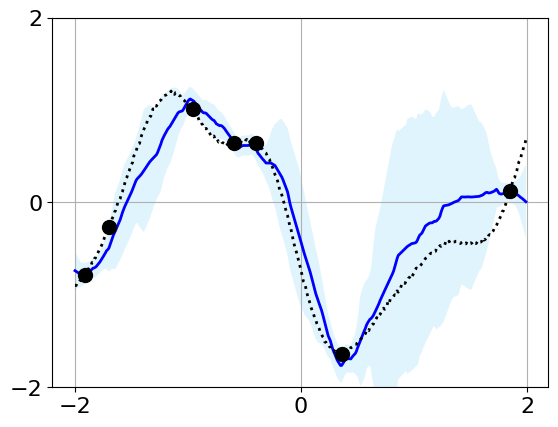

Training for 200000 epochs:  77%|███████▋  | 154989/200000 [06:56<01:44, 429.98it/s]

Loss: -2.4886634349823


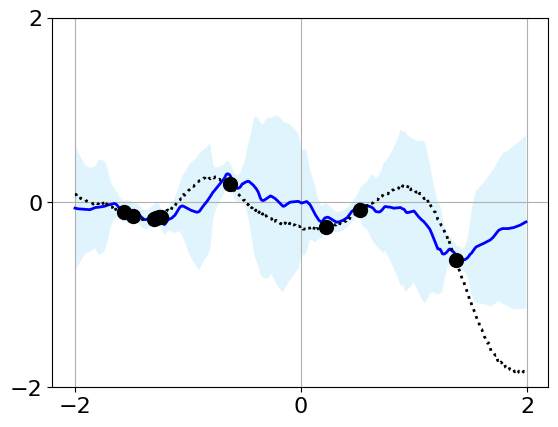

Training for 200000 epochs:  80%|███████▉  | 159986/200000 [07:09<01:50, 362.49it/s]

Loss: 1.6270029544830322


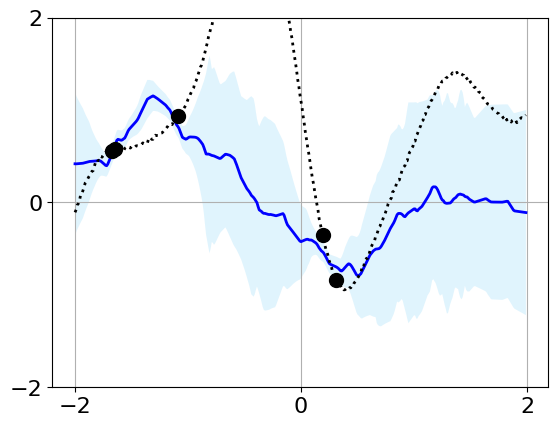

Training for 200000 epochs:  82%|████████▏ | 164971/200000 [07:22<01:23, 420.40it/s]

Loss: 2.5100367069244385


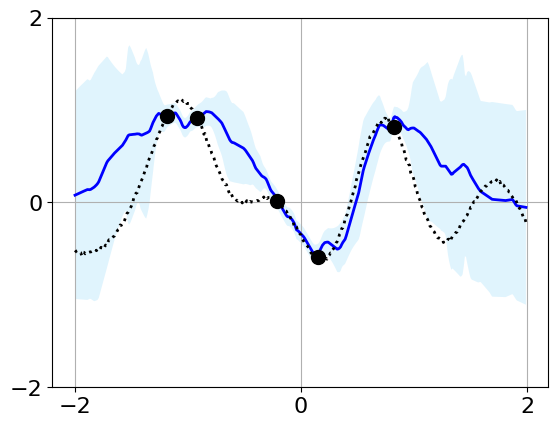

Training for 200000 epochs:  85%|████████▍ | 169996/200000 [07:35<01:20, 373.09it/s]

Loss: 1.4746527671813965


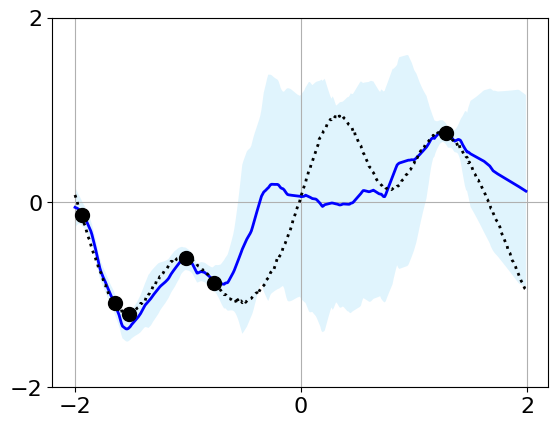

Training for 200000 epochs:  87%|████████▋ | 174973/200000 [07:47<00:58, 426.89it/s]

Loss: -1.9502637386322021


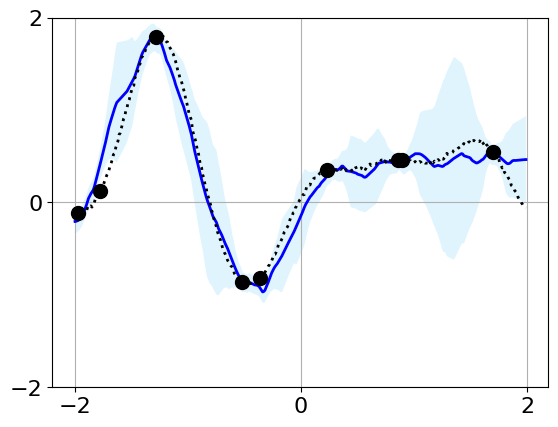

Training for 200000 epochs:  90%|████████▉ | 179998/200000 [07:59<00:47, 422.66it/s]

Loss: -5.383605480194092


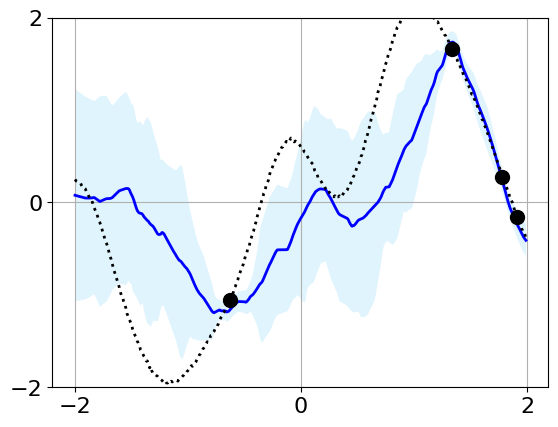

Training for 200000 epochs:  92%|█████████▏| 184982/200000 [08:13<00:40, 374.12it/s]

Loss: -6.734787940979004


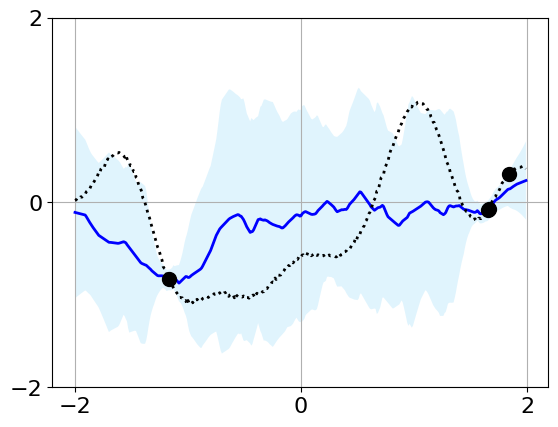

Training for 200000 epochs:  95%|█████████▍| 189967/200000 [08:26<00:26, 371.69it/s]

Loss: 0.7472568154335022


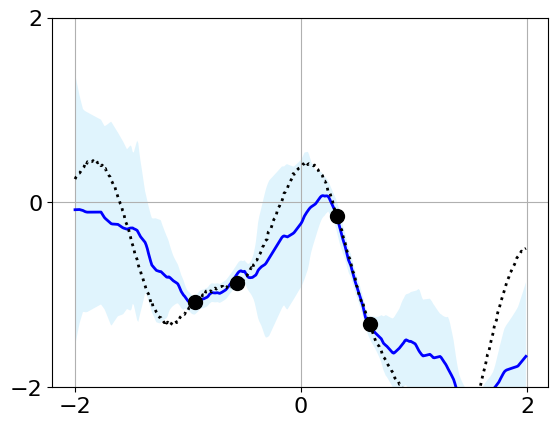

Training for 200000 epochs:  97%|█████████▋| 194978/200000 [08:39<00:13, 364.69it/s]

Loss: -4.346616744995117


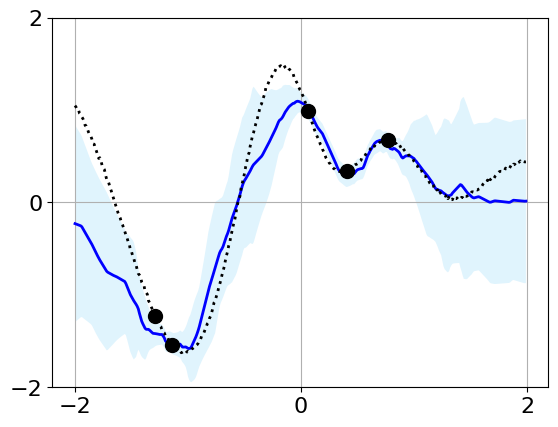

Training for 200000 epochs: 100%|█████████▉| 199974/200000 [08:53<00:00, 365.48it/s]

Loss: -3.8211679458618164


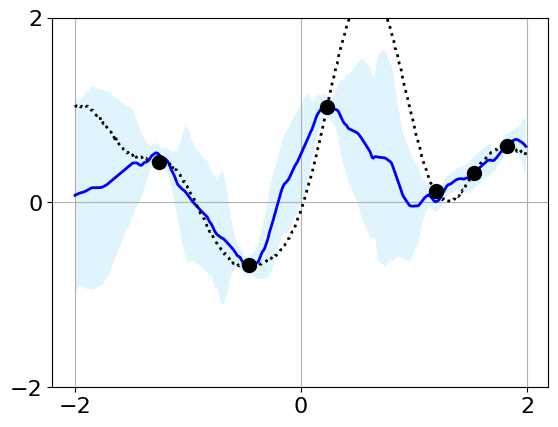

Training for 200000 epochs: 100%|██████████| 200000/200000 [08:53<00:00, 374.54it/s]


In [ ]:
deterministic_cnp = train(config=cfg, model=deterministic_cnp, data_train=data_train, data_test=data_test)